In [3]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

import time
import datetime

import json
import os
from dotenv import load_dotenv #pip install python-dotenv

from bs4 import BeautifulSoup
import requests 

from selenium import webdriver 
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import warnings
warnings.filterwarnings("ignore")

from my_functions import *

In [12]:
# comprovar quantes requests he fet i quantes me'n queden

url_search = "https://api.discogs.com/database/search"

params = {
    "type": "release"  # Search for masters
    , "format": "album"           # just search for albums
    , "per_page": 100    # Number of results per page (max 100)
    , "page": 1          # Start with page 1
    , 'country': 'UK'
    , "year": 2015
    , 'genre': 'Rock'
    # , "style": style
}

headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}
response = requests.get(url_search, headers=headers, params=params)

rate_limit = response.headers.get("X-Discogs-Ratelimit")
rate_limit_used = response.headers.get("X-Discogs-Ratelimit-Used")
rate_limit_remaining = response.headers.get("X-Discogs-Ratelimit-Remaining")

print(f"Rate Limit: {rate_limit}")
print(f"Rate Limit Used: {rate_limit_used}")
print(f"Rate Limit Remaining: {rate_limit_remaining}")

Rate Limit: 60
Rate Limit Used: 0
Rate Limit Remaining: 60


### **Proves**: un any en un país

In [ ]:
# get all rock_styles in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# genres = ["Blues", "Classical", "Electronic", "Folk, World, & Country", "Funk / Soul", "Hip-Hop", "Jazz", "Latin", "Pop", "Rock", "Stage & Screen"]
# rock_styles = ["Pop Rock", "Punk", "Alternative Rock", "Indie Rock", "Hardcore", "Rock & Roll", "Hard Rock", "Psychedelic Rock"
#               , "Black Metal", "Heavy Metal", "Folk Rock", "Experimental", "Prog Rock", "Death Metal", "Garage Rock"]

for year in range(1968, 1978):
    # Define parameters for artist search
    params = {
        "per_page": 100    # Number of results per page (max 100)
        , 'type': 'release'
        , 'format': 'album'
        , 'genre': 'Rock'

        # items to change
        , 'country': 'US'
        , 'year': year
        # , 'style': style
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    items_number = data['pagination']['items']  # number of items

    print(f"{year}: {items_number}")

1968: 4331
1969: 5284
1970: 5947
1971: 5817
1972: 6020
1973: 5976
1974: 5217
1975: 5824
1976: 6190
1977: 6693


In [31]:
# get one style in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# Define parameters for artist search
params = {
    "per_page": 100    # Number of results per page (max 100)
    , 'type': 'release'
    , 'format': 'album'
    , 'page': 1

    # items to change
    , 'country': 'US'
    , 'year': 1968
    , 'genre': 'Rock'
    # , 'style': 'Prog Rock'
}

response = requests.get(url, headers=headers, params=params)
data = response.json()
items_number = response.json()['pagination']['items']  # number of items

print(f"Items: {items_number}")

# response.json()

Items: 4331


### Chat-GPT **all albums, including where ``master_id = 0``** 

In [247]:
import requests
import time
import pandas as pd
import numpy as np

url_search = "https://api.discogs.com/database/search"
headers = {"User-Agent": "MyDiscogsApp", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

df_masters_scrapped = pd.read_csv('Datasets/df_masters.csv')

# Crear listas vacías
artist_id_list, artists_list, titles_list, years_list, release_countries_list = [], [], [], [], []
album_length_list, tracks_list, release_type_list, genres_list, styles_list = [], [], [], [], []
master_id_new_list, artist_profile_list, main_release_id_list = [], [], []

attempts, scrapped = 0, 0
start_year = 1962

def scrape_album_data(url, is_master):
    """Obtiene la información de un álbum o master desde Discogs."""
    response = requests.get(url, headers=headers)
    time.sleep(1)
    data = response.json()

    artist = data['artists'][0]['name']
    if artist == 'Various':
        return None  # No quiero recopilatorios
    
    title = data['title']
    release_year = data['year']
    genres = data.get('genres', [])
    styles = data.get('styles', [])
    
    # Calcular la duración total del álbum
    number_of_songs = len(data.get('tracklist', []))
    song_durations = []
    
    for song in data.get('tracklist', []):
        song_duration = song.get('duration', '')
        try:
            minutes, seconds = map(int, song_duration.split(':'))
            song_durations.append(minutes + seconds / 60)
        except:
            pass
    
    album_length = round(sum(song_durations), 2)
    artist_id = data['artists'][0]['id']
    
    if is_master:
        main_release_id = data['main_release']
        release_url = f"https://api.discogs.com/releases/{main_release_id}"
    else:
        main_release_id = data['id']
        release_url = url
    
    # Obtener país y formato de la edición principal
    response = requests.get(release_url, headers=headers)
    time.sleep(1)
    release_data = response.json()
    
    release_country = release_data.get('country', 'Unknown')
    release_type = release_data.get('formats', [{}])[0].get('descriptions', ['Unknown'])
    
    # Obtener información del artista
    artist_url = f"https://api.discogs.com/artists/{artist_id}"
    response = requests.get(artist_url, headers=headers)
    time.sleep(1)
    artist_data = response.json()
    
    artist_profile = artist_data.get('profile', np.nan)
    
    return {
        "artist_id": str(artist_id),
        "artist": artist,
        "title": title,
        "release_year": release_year,
        "genres": genres,
        "styles": styles,
        "master_id": data.get('id') if is_master else np.nan,
        "album_length": album_length,
        "tracks": number_of_songs,
        "release_country": release_country,
        "release_type": release_type,
        "artist_profile": artist_profile,
        "main_release_id": main_release_id
    }

for year in range(start_year, start_year-3, -1):
    print(f'Year: {year}')

    params = {
        "type": "release",
        "format": "album",
        "per_page": 100,
        "page": 1,
        "country": "UK",
        "year": year,
        "genre": "Rock"
    }

    response1 = requests.get(url_search, headers=headers, params=params)
    time.sleep(1)
    data1 = response1.json()

    items = data1['pagination']['items']
    print(f'Items: {items} releases')

    pages = data1['pagination']['pages'] + 1

    for page in range(1, pages):
        print(f'------------ Page: {page} of {pages-1}, {year} -------------')

        params['page'] = page
        response2 = requests.get(url_search, headers=headers, params=params)
        time.sleep(1)
        data2 = response2.json()

        for result in data2['results']:
            try:
                attempts += 1
                time.sleep(1)

                master_id = result.get('master_id', 0)
                release_id = result['id']

                # Si master_id == 0, usa release_id, de lo contrario, usa master_id
                if master_id == 0:
                    url = f"https://api.discogs.com/releases/{release_id}"
                else:
                    if master_id in master_id_new_list or master_id in df_masters_scrapped['master_id'].values:
                        print(f'{attempts} attempts - {scrapped} scrapped - master_id {master_id} already scrapped')
                        continue
                    url = f"https://api.discogs.com/masters/{master_id}"
                
                album_data = scrape_album_data(url, is_master=(master_id != 0))
                
                if album_data:
                    artist_id_list.append(album_data["artist_id"])
                    artists_list.append(album_data["artist"])
                    titles_list.append(album_data["title"])
                    years_list.append(album_data["release_year"])
                    genres_list.append(album_data["genres"])
                    styles_list.append(album_data["styles"])
                    master_id_new_list.append(album_data["master_id"])
                    album_length_list.append(album_data["album_length"])
                    tracks_list.append(album_data["tracks"])
                    release_countries_list.append(album_data["release_country"])
                    release_type_list.append(album_data["release_type"])
                    artist_profile_list.append(album_data["artist_profile"])
                    main_release_id_list.append(album_data["main_release_id"])
                    
                    scrapped += 1

                    print(f'{attempts} attempts - {scrapped} scrapped - {album_data["artist"]} - {album_data["title"]}')
                
            except Exception as e:
                print(f'Error en {release_id}: {e}')
                continue


Year: 1962
Items: 104 releases
------------ Page: 1 of 2, 1962 -------------
1 attempts - 1 scrapped - Joey Dee & The Starliters - Back At The Peppermint Lounge / Twistin'
2 attempts - 1 scrapped - master_id 701508 already scrapped
3 attempts - 2 scrapped - Sandy Nelson - Teenage House Party
4 attempts - 3 scrapped - Chubby Checker - Twist-A-Long With Chubby Checker
5 attempts - 3 scrapped - master_id 340807 already scrapped
6 attempts - 4 scrapped - Sandy Nelson - Drummin' Up A Storm
7 attempts - 5 scrapped - Gary U.S. Bonds - Twist Up Calypso
8 attempts - 5 scrapped - master_id 573548 already scrapped
9 attempts - 5 scrapped - master_id 459934 already scrapped
10 attempts - 5 scrapped - master_id 393302 already scrapped
11 attempts - 5 scrapped - master_id 391578 already scrapped
12 attempts - 5 scrapped - master_id 459934 already scrapped
13 attempts - 5 scrapped - master_id 459934 already scrapped
14 attempts - 6 scrapped - The Champs - Great Dance Hits
15 attempts - 6 scrapped - m

In [249]:
minutes = 12
attempts = 271

seconds_per_attempt = minutes*60/attempts
seconds_per_attempt 

2.6568265682656826

### defining the function to get all albums, including where ``master_id = 0``

In [ ]:
def get_masters_us(start_year, final_year, step):
    url_search = "https://api.discogs.com/database/search"
    headers = {"User-Agent": "MyDiscogsApp", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

    # import the df that contains all the albums already scrapped (mosty from the UK)
    df_masters_scrapped = pd.read_csv('Datasets/df_masters.csv')

    # import the df of the albums from the US scrapped so far (from 1960)
    df_us_masters_scrapped = pd.read_csv('Datasets/df_us_masters.csv')

    # create empty lists
    artist_id_list = []
    artists_list = []
    titles_list = []
    years_list = []
    release_countries_list = []
    album_length_list = []
    tracks_list = []
    release_type_list = []
    genres_list = []
    styles_list = []
    master_id_new_list = []
    artist_profile_list = []
    main_release_id_list = []

    attempts = 0
    scrapped = 0

    for year in range(start_year, final_year, step):
        print(f'Year: {year}')

        # Define parameters for album search
        params = {
            "type": "release"  # Search for masters
            , "format": "album"           # just search for albums
            , "per_page": 100    # Number of results per page (max 100)
            , "page": 1          # Start with page 1
            , 'country': 'US'
            , "year": year
            , 'genre': 'Rock'
        }

        response1 = requests.get(url_search, headers=headers, params=params)
        time.sleep(1)
        data1 = response1.json()

        items = data1['pagination']['items']
        print(f'Items: {items} releases')

        pages = data1['pagination']['pages']+1
        
        for page in range(1, pages):
            print(f'------------ Page: {page} of {pages-1}, {year} -------------')

            params['page'] = page     # change pages
            response2 = requests.get(url_search, headers=headers, params=params)
            data2 = response2.json()

            for id in range(len(data2['results'])):
                try:
                    attempts+=1
                    time.sleep(1)
                    master_id = data2['results'][id]['master_id']
                    release_id = data2['results'][id]['id']

                    if master_id == 0:
                        print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id}')

                        url_release = f"https://api.discogs.com/releases/{release_id}"
                        response3 = requests.get(url_release, headers=headers)
                        # time.sleep(1)
                        data3 = response3.json()
                        artist = data3['artists'][0]['name']
                        title = data3['title']

                        if ((df_masters_scrapped['artist'] == artist) & (df_masters_scrapped['title'] == title)).any() or \
                            ((df_us_masters_scrapped['artist'] == artist) & (df_us_masters_scrapped['title'] == title)).any():
                            print(f"Album already scrapped: {artist} - {title}")
                            continue

                        elif (artist, title) in zip(artists_list, titles_list):
                            print(f"Album already scrapped right now: {artist} - {title}") 
                            continue        

                        else:
                            try:
                                if artist == 'Various':
                                        print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - release_id {release_id}: Compilation') 
                                        continue   # I don't want compilations
                                else:
                                # define the data I want to get
                                    release_year = data3['year']                
                                    genres = data3['genres']
                                    styles = data3['styles']
                                    if 'Rock' not in genres:
                                        print('Not a rock album. Skipping')
                                        continue    # I only want rock albums

                                # a more complex information is the total duration of the album, I have to sum the durations of each song
                                    number_of_songs = len(data3['tracklist'])
                                    song_durations = []

                                    for song in range(number_of_songs):
                                        song_duration = data3['tracklist'][song]['duration']
                                        try:
                                            minutes, seconds = map(int, song_duration.split(':'))
                                            song_duration_minutes = minutes + seconds/60
                                            song_durations.append(song_duration_minutes)
                                        except:
                                            pass
                                        album_length = round(sum(song_durations), 2)

                                    artist_id = data3['artists'][0]['id']

                                # define the data I want to get
                                    release_country = data3['country']
                                    release_type = data3['formats'][0]['descriptions']
                                    if 'Compilation' in release_type:
                                        print('Compilation detected. Skipping')
                                        continue    # pass to the next album, I don't want compilations

                                # artist page
                                    url = f"https://api.discogs.com/artists/{artist_id}"
                                    time.sleep(1)
                                    response5 = requests.get(url, headers=headers)
                                    data5 = response5.json()

                                # define the data I want to get
                                    try:
                                        artist_profile = data5['profile']
                                    except:
                                        artist_profile = np.nan
                                        pass

                                # save the info in the lists
                                    artist_id_list.append(str(artist_id))
                                    artists_list.append(artist)
                                    titles_list.append(title)
                                    years_list.append(release_year)
                                    genres_list.append(genres)
                                    styles_list.append(styles)
                                    master_id_new_list.append(0)
                                    album_length_list.append(album_length)
                                    tracks_list.append(number_of_songs)
                                    release_countries_list.append(release_country)
                                    release_type_list.append(release_type)
                                    main_release_id_list.append(release_id)

                                    if artist_profile == '':
                                        artist_profile_list.append(np.nan)
                                    else:
                                        artist_profile_list.append(artist_profile)

                                    scrapped+=1

                                # list lengths
                                    lists = [artist_id_list, main_release_id_list, master_id_new_list, release_countries_list, artists_list, titles_list, album_length_list
                                            , tracks_list, release_type_list, genres_list, styles_list, artist_profile_list, years_list]

                                # Check if all lists have the same length
                                    lengths = [len(lst) for lst in lists]
                                    if len(set(lengths)) != 1:
                                        print("Lengths are not the same.")
                                        break # stop the loop, I won't be able to store the data if I have one value missing

                                    print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - release_id {release_id}: {artist} - {title}')
                                    # time.sleep(1)
                            except:
                                print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - release_id {release_id}: {artist} - {title} - Album not found')
                                continue    # sometimes it crashes for some unknown reason, so I skip this album and continue
                    
                    # if it's an album that I have already scrapped in this current code
                    elif master_id in master_id_new_list:
                        print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id} already in list') 
                        # time.sleep(1)
                        continue        # there are several releases of the same master_release, I just want one (the master_release)

                    elif (master_id in df_masters_scrapped['master_id'].values) or \
                        (master_id in df_us_masters_scrapped['master_id'].values):
                        print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id} already scrapped')
                        # time.sleep(1) 
                        continue        # I have already scrapped it before

                    else:
                        url_master = f"https://api.discogs.com/masters/{master_id}"
                        response3 = requests.get(url_master, headers=headers)
                        time.sleep(1)
                        data3 = response3.json()

                        artist = data3['artists'][0]['name']

                        if artist == 'Various':
                                print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id}: Compilation') 
                                continue   # I don't want compilations
                        else:
                        # define the data I want to get
                            title = data3['title']
                            release_year = data3['year']                 
                            genres = data3['genres']
                            styles = data3['styles']
                            if 'Rock' not in genres:
                                print('Not a rock album. Skipping')
                                continue    # I only want rock albums
                            
                        # a more complex information is the total duration of the album, I have to sum the durations of each song
                            number_of_songs = len(data3['tracklist'])
                            song_durations = []

                            for song in range(number_of_songs):
                                song_duration = data3['tracklist'][song]['duration']
                                try:
                                    minutes = int(song_duration.split(':')[0])
                                    seconds = int(song_duration.split(':')[1])
                                    song_duration_minutes = minutes + seconds/60
                                    song_durations.append(song_duration_minutes)
                                except:
                                    pass
                                album_length = round(sum(i for i in song_durations), 2)

                            main_release_id = data3['main_release']
                            artist_id = data3['artists'][0]['id']

                        # release page
                            url = f"https://api.discogs.com/releases/{main_release_id}"
                            # time.sleep(1)
                            response4 = requests.get(url, headers=headers)
                            data4 = response4.json()

                        # define the data I want to get
                            release_country = data4['country']
                            release_type = data4['formats'][0]['descriptions']
                            if 'Compilation' in release_type:
                                print('Compilation detected. Skipping')
                                continue    # pass to the next album, I don't want compilations

                        # artist page
                            url = f"https://api.discogs.com/artists/{artist_id}"
                            # time.sleep(1)
                            response5 = requests.get(url, headers=headers)
                            data5 = response5.json()

                        # define the data I want to get
                            try:
                                artist_profile = data5['profile']
                            except:
                                artist_profile = np.nan
                                pass

                        # save the info in the lists
                            artist_id_list.append(str(artist_id))
                            artists_list.append(artist)
                            titles_list.append(title)
                            years_list.append(release_year)
                            genres_list.append(genres)
                            styles_list.append(styles)
                            master_id_new_list.append(master_id)
                            album_length_list.append(album_length)
                            tracks_list.append(number_of_songs)
                            release_countries_list.append(release_country)
                            release_type_list.append(release_type)
                            main_release_id_list.append(main_release_id)

                            if artist_profile == '':
                                artist_profile_list.append(np.nan)
                            else:
                                artist_profile_list.append(artist_profile)

                            scrapped+=1

                        # list lengths
                            lists = [artist_id_list, main_release_id_list, master_id_new_list, release_countries_list, artists_list, titles_list, album_length_list
                                    , tracks_list, release_type_list, genres_list, styles_list, artist_profile_list, years_list]

                        # Check if all lists have the same length
                            lengths = [len(lst) for lst in lists]
                            if len(set(lengths)) != 1:
                                print("Lengths are not the same.")
                                break # stop the loop, I won't be able to store the data if I have one value missing

                            print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id}: {artist} - {title}')
                            # time.sleep(1)

                        # save the data in a df and export it
                            data = pd.DataFrame({'artist_id': artist_id_list
                            , 'master_id': master_id_new_list
                            , 'main_release_id': main_release_id_list
                            , 'release_country': release_countries_list
                            , 'artist': artists_list
                            , 'title': titles_list
                            , 'year': years_list
                            , 'album_length': album_length_list
                            , 'tracks': tracks_list
                            , 'release_type': release_type_list
                            , 'genres': genres_list
                            , 'styles': styles_list
                            , 'artist_profile': artist_profile_list})

                            data.to_csv(f'Datasets/df_us_{year}.csv', index=False)
                except:
                    print('Strange error')
                    continue    # sometimes it crashes for some unknown reason, so I skip this album and continue

### **Actual code to get all albums**

From 1995 there are more than 10.000 albums for each year, so I'd have to iterate over styles as well

In [10]:
get_masters_us(1968, 1969, 1)

Year: 1968
Items: 4332 releases
------------ Page: 1 of 44, 1968 -------------
1 attempts - 0 scrapped - 1/4332 - master_id 58808 already scrapped
2 attempts - 0 scrapped - 2/4332 - master_id 196493 already scrapped
3 attempts - 1 scrapped - 3/4332 - master_id 448995: Orpheus (5) - Ascending
4 attempts - 1 scrapped - 4/4332 - master_id 45365 already scrapped
5 attempts - 1 scrapped - 5/4332 - master_id 138476 already scrapped
6 attempts - 1 scrapped - 6/4332 - master_id 49058 already scrapped
7 attempts - 1 scrapped - 7/4332 - master_id 131511 already scrapped
8 attempts - 1 scrapped - 8/4332 - master_id 90268 already scrapped
9 attempts - 1 scrapped - 9/4332 - master_id 14468 already scrapped
10 attempts - 1 scrapped - 10/4332 - master_id 87224 already scrapped
11 attempts - 1 scrapped - 11/4332 - master_id 68815 already scrapped
12 attempts - 1 scrapped - 12/4332 - master_id 361525 already scrapped
13 attempts - 1 scrapped - 13/4332 - master_id 35124 already scrapped
14 attempts - 1 

In [11]:
minutes = 93
attempts = 4331 

seconds_per_attempt = minutes*60/attempts
seconds_per_attempt 

1.2883860540290926

### **Rock masters from a specific country**

In [2]:
df_masters_scrapped = pd.read_csv('Datasets/df_masters.csv')
df_masters_scrapped.shape

(43833, 13)

In [25]:
url_search = "https://api.discogs.com/database/search"
headers = {"User-Agent": "MyDiscogsApp", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

df_masters_scrapped = pd.read_csv('Datasets/df_masters.csv')

# rock_styles = ["Pop Rock", "Punk", "Alternative Rock", "Indie Rock", "Hardcore", "Rock & Roll", "Hard Rock", "Psychedelic Rock"
#               , "Black Metal", "Heavy Metal", "Folk Rock", "Experimental", "Prog Rock", "Death Metal", "Garage Rock"]

# create empty lists
artist_id_list = []
artists_list = []
titles_list = []
years_list = []
release_countries_list = []
album_length_list = []
tracks_list = []
release_type_list = []
genres_list = []
styles_list = []
master_id_new_list = []
artist_profile_list = []
main_release_id_list = []

attempts = 0
scrapped = 0
start_year = 1983

for year in range(start_year, start_year-1, -1):
    print(f'Year: {year}')

    # for style in rock_styles:
    #     print(f'Style: {style}')

    # Define parameters for album search
    params = {
        "type": "release"  # Search for masters
        , "format": "album"           # just search for albums
        , "per_page": 100    # Number of results per page (max 100)
        , "page": 1          # Start with page 1
        , 'country': 'UK'
        , "year": year
        , 'genre': 'Rock'
    }

    response1 = requests.get(url_search, headers=headers, params=params)
    time.sleep(1)
    data1 = response1.json()

    items = data1['pagination']['items']
    print(f'Items: {items} releases')

    pages = data1['pagination']['pages']+1
    
    for page in range(1, pages):
        print(f'------------ Page: {page} of {pages-1}, {year} -------------')

        params['page'] = page     # change pages
        response2 = requests.get(url_search, headers=headers, params=params)
        data2 = response2.json()

        for id in range(len(data2['results'])):
            try:
                attempts+=1
                time.sleep(1)

                master_id = data2['results'][id]['master_id']

                if master_id == 0:
                    print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id}')
                    continue        # I cannot get info 
                elif master_id in master_id_new_list:
                    print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id} already in list') 
                    continue        # there are several releases of the same master_release, I just want one (the master_release)
                elif master_id in df_masters_scrapped['master_id'].values:
                    print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id} already scrapped') 
                    continue        # I have already scrapped it before
                else:
                    url_master = f"https://api.discogs.com/masters/{master_id}"
                    response3 = requests.get(url_master, headers=headers)
                    time.sleep(1)
                    data3 = response3.json()

                    artist = data3['artists'][0]['name']

                    if artist == 'Various':
                            print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id}: Compilation') 
                            continue   # I don't want compilations
                    else:
                    # define the data I want to get
                        title = data3['title']
                        release_year = data3['year']                 
                        genres = data3['genres']
                        styles = data3['styles']

                    # a more complex information is the total duration of the album, I have to sum the durations of each song
                        number_of_songs = len(data3['tracklist'])
                        song_durations = []

                        for song in range(number_of_songs):
                            song_duration = data3['tracklist'][song]['duration']
                            try:
                                minutes = int(song_duration.split(':')[0])
                                seconds = int(song_duration.split(':')[1])
                                song_duration_minutes = minutes + seconds/60
                                song_durations.append(song_duration_minutes)
                            except:
                                pass
                            album_length = round(sum(i for i in song_durations), 2)

                        main_release_id = data3['main_release']
                        artist_id = data3['artists'][0]['id']

                    # release page
                        url = f"https://api.discogs.com/releases/{main_release_id}"
                        time.sleep(1)
                        response4 = requests.get(url, headers=headers)
                        data4 = response4.json()

                    # define the data I want to get
                        release_country = data4['country']
                        release_type = data4['formats'][0]['descriptions']

                    # artist page
                        url = f"https://api.discogs.com/artists/{artist_id}"
                        time.sleep(1)
                        response5 = requests.get(url, headers=headers)
                        data5 = response5.json()

                    # define the data I want to get
                        try:
                            artist_profile = data5['profile']
                        except:
                            artist_profile = np.nan
                            pass

                    # save the info in the lists
                        artist_id_list.append(str(artist_id))
                        artists_list.append(artist)
                        titles_list.append(title)
                        years_list.append(release_year)
                        genres_list.append(genres)
                        styles_list.append(styles)
                        master_id_new_list.append(master_id)
                        album_length_list.append(album_length)
                        tracks_list.append(number_of_songs)
                        release_countries_list.append(release_country)
                        release_type_list.append(release_type)
                        main_release_id_list.append(main_release_id)

                        if artist_profile == '':
                            artist_profile_list.append(np.nan)
                        else:
                            artist_profile_list.append(artist_profile)

                        scrapped+=1

                    # list lengths
                        lists = [artist_id_list, main_release_id_list, master_id_new_list, release_countries_list, artists_list, titles_list, album_length_list
                                , tracks_list, release_type_list, genres_list, styles_list, artist_profile_list, years_list]

                    # Check if all lists have the same length
                        lengths = [len(lst) for lst in lists]
                        if len(set(lengths)) != 1:
                            print("Lengths are not the same.")
                            break # stop the loop, I won't be able to store the data if I have one value missing

                        print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id}: {artist} - {title}')
                        time.sleep(1)
            except:
                print('Strange error')
                continue    # sometimes it crashes for some unknown reason, so I skip this album and continue

Year: 1983
Items: 2272 releases
------------ Page: 1 of 23, 1983 -------------
1 attempts - 0 scrapped - 1/2272 - master_id 33650 already scrapped
2 attempts - 0 scrapped - 2/2272 - master_id 35357 already scrapped
3 attempts - 0 scrapped - 3/2272 - master_id 48240 already scrapped
4 attempts - 1 scrapped - 4/2272 - master_id 114659: Chris Rea - Water Sign
5 attempts - 1 scrapped - 5/2272 - master_id 16101 already scrapped
6 attempts - 1 scrapped - 6/2272 - master_id 254300 already scrapped
7 attempts - 2 scrapped - 7/2272 - master_id 677394: Katrina And The Waves - Shock Horror!
8 attempts - 2 scrapped - 8/2272 - master_id 95233 already scrapped
9 attempts - 3 scrapped - 9/2272 - master_id 88994: Pat Benatar - Live From Earth
10 attempts - 4 scrapped - 10/2272 - master_id 422647: Buddy Holly - For The First Time Anywhere
11 attempts - 4 scrapped - 11/2272 - master_id 28911 already scrapped
12 attempts - 4 scrapped - 12/2272 - master_id 33671 already scrapped
13 attempts - 5 scrapped -

In [ ]:
# UK 1991

# Pop Rock: 708
# Punk: 354
# Alternative Rock: 414
# Indie Rock: 490
# Hardcore: 103
# Rock & Roll: 111
# Hard Rock: 318
# Psychedelic Rock: 180
# Black Metal: 6
# Heavy Metal: 187
# Folk Rock: 311
# Experimental: 122
# Prog Rock: 191
# Death Metal: 63
# Garage Rock: 69

453+904+731+976+254+154+312+633+146+197+326+465+399+133+141

2922

In [26]:
(79*60)/2272

2.086267605633803

### **Importing the data**

Since the information in the lists exist only inside the function, I had to create the df and export it in order to save the information, so now I have to import it again.

In [13]:
data = pd.read_csv('Datasets/df_us_1968.csv')

In [14]:
print(f'{data.shape[0]} releases\n{data.artist.nunique()} different artists')

469 releases
435 different artists


In [15]:
data.sample(5)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
451,1731462.0,232271,5939720,US,Levitts,We Are The Levitts,1968,85.28,26,"['LP', 'Album']","['Jazz', 'Rock', 'Pop']",[],NaN
300,266389.0,532894,4234793,UK,The Johnny Mann Singers,This Guy's In Love With You. The Look Of Love,1968,0.00,12,"['LP', 'Album']","['Jazz', 'Pop']",['Easy Listening'],American vocal group formed by [a=Johnny Mann]...
88,978138.0,678932,11399672,US,The Tuneful Trolley,Island In The Sky,1968,25.08,11,"['LP', 'Album', 'Stereo']",['Rock'],"['Psychedelic Rock', 'Pop Rock']",NaN
341,319876.0,1755401,3156583,US,Chris & Peter Allen,Album #1,1968,25.92,10,"['LP', 'Album']","['Rock', 'Funk / Soul', 'Pop']","['Pop Rock', 'Soul', 'Ballad', 'Vocal', 'Sunsh...",Australian popular cabaret and television act ...
119,116329.0,291469,2579281,US,The Fireballs,Bottle Of Wine,1968,29.55,12,"['LP', 'Album', 'Stereo']",['Rock'],[],"US rock and roll group, formed 1957 in Raton, ..."


In [16]:
data.release_country.value_counts().head()

release_country
US           426
UK            16
Canada         8
Mexico         5
Argentina      2
Name: count, dtype: int64

In [17]:
data.year.value_counts().head()

year
1968    451
0         6
1969      5
1967      3
1966      2
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='year'>

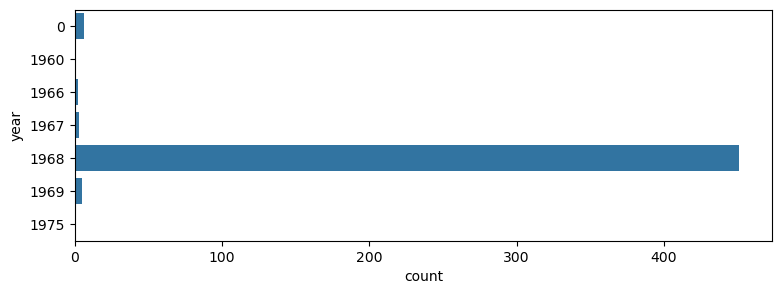

In [18]:
plt.figure(figsize=(9,3))
sns.countplot(data=data, y='year')

In [19]:
data[['artist', 'title', 'album_length']].duplicated().sum()

3

In [31]:
data[data[['artist', 'title', 'album_length', 'tracks']].duplicated()]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
19,83908.0,114372,1467625,US,Sweetwater,Sweetwater,1968,36.10,11,"['LP', 'Album']",['Rock'],"['Folk Rock', 'Psychedelic Rock']",American Rock band formed in Los Angeles aroun...
124,1066485.0,291187,1261345,US,The Candymen,The Candymen Bring You Candy Power,1968,27.65,11,"['LP', 'Album', 'Stereo']",['Rock'],"['Psychedelic Rock', 'Pop Rock']",NaN
376,59246.0,29548,1138006,US,Muddy Waters,Electric Mud,1968,35.88,8,"['LP', 'Album', 'Stereo']","['Rock', 'Funk / Soul', 'Blues']","['Electric Blues', 'Chicago Blues', 'Psychedel...","American blues guitarist, singer and composer...."


In [30]:
data[data['title']=='Electric Mud']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
346,59246.0,0,13437728,US,Muddy Waters,Electric Mud,1968,35.88,8,"['LP', 'Album']","['Rock', 'Funk / Soul', 'Blues']","['Electric Blues', 'Chicago Blues', 'Psychedel...","American blues guitarist, singer and composer...."
376,59246.0,29548,1138006,US,Muddy Waters,Electric Mud,1968,35.88,8,"['LP', 'Album', 'Stereo']","['Rock', 'Funk / Soul', 'Blues']","['Electric Blues', 'Chicago Blues', 'Psychedel...","American blues guitarist, singer and composer...."


### **Concat with the previous df**

In [20]:
# import the last df
df_masters = pd.read_csv('Datasets/df_us_masters.csv')
df_masters.shape

(1713, 13)

In [21]:
# concat with the df of the albums I just scrapped
df_masters_concat = pd.concat([df_masters, data])
df_masters_concat.reset_index(drop=True, inplace=True)
df_masters_concat.shape

(2182, 13)

In [25]:
df_masters_concat[df_masters_concat[['artist', 'title']].duplicated()]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
1149,65376.0,221392,7823727,US,The Ventures,The Ventures,1966,25.75,12,"['LP', 'Album', 'Mono']",['Rock'],['Rock & Roll'],American instrumental rock group formed in 195...
1174,182608.0,559852,2720123,US,B.J. Thomas,I'm So Lonesome I Could Cry,1966,32.62,12,"['LP', 'Album', 'Mono']",['Rock'],['Pop Rock'],"B.J. Thomas (born August 7, 1942, Hugo, Oklaho..."
1732,83908.0,114372,1467625,US,Sweetwater,Sweetwater,1968,36.10,11,"['LP', 'Album']",['Rock'],"['Folk Rock', 'Psychedelic Rock']",American Rock band formed in Los Angeles aroun...
1749,1038775.0,563329,9747954,US,Index (16),Index,1968,31.63,9,"['LP', 'Album']",['Rock'],['Garage Rock'],Index were a psychedelic/garage rock band from...
1837,1066485.0,291187,1261345,US,The Candymen,The Candymen Bring You Candy Power,1968,27.65,11,"['LP', 'Album', 'Stereo']",['Rock'],"['Psychedelic Rock', 'Pop Rock']",NaN
2089,59246.0,29548,1138006,US,Muddy Waters,Electric Mud,1968,35.88,8,"['LP', 'Album', 'Stereo']","['Rock', 'Funk / Soul', 'Blues']","['Electric Blues', 'Chicago Blues', 'Psychedel...","American blues guitarist, singer and composer...."


In [21]:
df_masters_concat[df_masters_concat['title']=='Spotlight On Jackie Wilson']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
1064,69375,0,14975388,US,Jackie Wilson,Spotlight On Jackie Wilson,1965,34.68,12,"[LP, Album, Mono]","[Rock, Funk / Soul, Pop, Folk, World, & Country]",[Vocal],"Jackie Wilson (born June 9, 1934, Detroit, Mic..."
1066,69375,551554,4378040,US,Jackie Wilson,Spotlight On Jackie Wilson,1965,34.68,12,"[LP, Album, Mono]","[Rock, Funk / Soul, Pop, Folk, World, & Country]",[Vocal],"Jackie Wilson (born June 9, 1934, Detroit, Mic..."


In [23]:
# check one by one if necessary
try:
    df_masters_concat.drop([1064], axis=0, inplace=True)
    print('Rows dropped')
    print(df_masters_concat.shape)
except:
    print("Couldn't drop these rows")
    print(df_masters_concat.shape)

Rows dropped
(1716, 13)


In [24]:
check_duplicates_albums(df_masters_concat)

Found 3 duplicates
Resulting dataset: (1713, 13)


In [25]:
print(f'{df_masters_concat.shape[0]} releases\n{df_masters_concat.artist.nunique()} different artists')

1713 releases
1151 different artists


### **Exporting to csv**

In [26]:
df_masters_concat.to_csv('Datasets/df_us_masters.csv', index=False)

### **Statistics**

In [61]:
# import the last df
df_masters = pd.read_csv('Datasets/df_us_masters.csv')
df_masters.shape

(342, 13)

<Axes: xlabel='count', ylabel='year'>

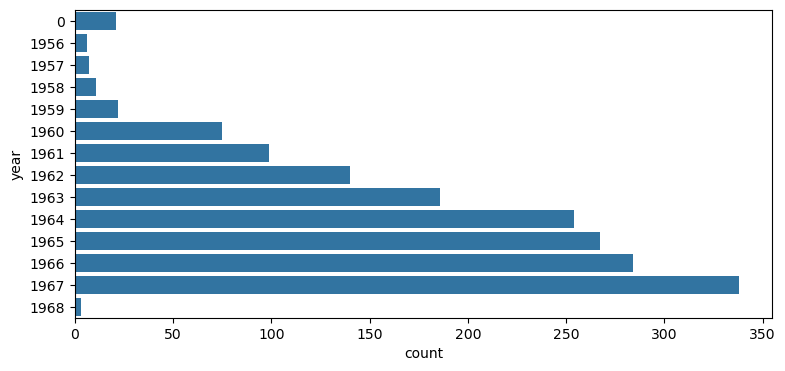

In [27]:
plt.figure(figsize=(9,4))
sns.countplot(data=df_masters_concat, y='year')

In [63]:
df_masters_concat.release_country.value_counts().head(10)

release_country
US             326
Italy            4
UK               4
Mexico           3
Canada           2
Netherlands      2
Name: count, dtype: int64

In [64]:
df_masters_concat.artist.value_counts().head(10)

artist
Chubby Checker        6
Jimmy Clanton         4
Bobby Rydell          3
Dave "Baby" Cortez    3
Paul Evans            3
Conway Twitty         3
Fabian (6)            3
Lloyd Price           3
Santo & Johnny        3
The Olympics          3
Name: count, dtype: int64

In [65]:
df_masters_concat.genres.value_counts().head(10)

genres
['Rock']                                     54
[Rock]                                       42
['Rock', 'Pop']                              33
[Rock, Pop]                                  25
['Rock', 'Funk / Soul']                      20
[Pop]                                        12
[Rock, Funk / Soul]                          11
['Rock', 'Folk, World, & Country']           10
['Rock', 'Pop', 'Folk, World, & Country']     8
['Jazz', 'Rock']                              8
Name: count, dtype: int64

In [66]:
df_masters_concat.styles.value_counts().head(10)

styles
[]                               24
['Rock & Roll']                  21
[Rock & Roll, Twist]             16
['Doo Wop']                      11
[]                               11
[Rock & Roll]                    11
[Twist]                           7
['Rhythm & Blues', 'Doo Wop']     7
['Country']                       6
['Vocal']                         6
Name: count, dtype: int64

In [67]:
df_masters_concat[df_masters_concat['release_country']=='Europe'].sort_values('artist')

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [68]:
percentage_album_length_missing = round((df_masters_concat['album_length']==0).sum() / df_masters_concat.shape[0] * 100, 2)
print(f'% missing album_length: {percentage_album_length_missing}%')

% missing album_length: 40.35%


In [69]:
df_masters_concat['artist_profile'].isna().sum()

57

In [70]:
percentage_artist_profile_missing = round(df_masters_concat['artist_profile'].isna().sum() / df_masters_concat.shape[0] * 100, 2)
print(f'% missing artist_profile: {percentage_artist_profile_missing}%')

% missing artist_profile: 16.67%


In [36]:
df_masters_concat[df_masters_concat['artist_profile']==''] # should be empty

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [19]:
df_masters_concat.loc[10, 'artist_profile']

'English Pop punk band from Southend-on-Sea, Essex, consisting of James Bourne, Matt Willis and Charlie Simpson. Formed in 2000, the band had four UK number-one singles, won two Brit awards and have released four studio albums, selling in excess of five million records.\r\n\r\nIn 2003, Dutch releases of this band were released under the artist name "Bust" to avoid confusion with Dutch band [a493201] who had a hit back then with "We Want More".'

In [37]:
df_masters_concat.groupby(["release_country", 'year']).agg({'master_id': 'count'}).sort_values('master_id', ascending=False).astype(int).head(15)

master_id
release_country year           
US              1961         92
                1960         70
                1959         10
                1958          5
                1956          3
Italy           1961          2
Canada          1960          1
Italy           1960          1
Mexico          1960          1
Netherlands     1961          1
UK              0             1
                1960          1
                1961          1
US              0             1
                1957          1